In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import batman
from ldtk import SVOFilter, LDPSetCreator
%matplotlib widget

In [4]:
taste_target_dictionary = pickle.load(open('../Results/TASTE/target_dictionary.p', 'rb'))
taste_bjd = taste_target_dictionary['time']
differential_allref = pickle.load(open('../Results/TASTE/differential_allref.p', 'rb'))
normalized_differential_allref = pickle.load(open('../Results/TASTE/normalized_diff_allref.p', 'rb'))

tess_sector76_dictionary = pickle.load(open('../Results/TESS/sector76_flatten.p', 'rb'))
tess_bjd = tess_sector76_dictionary['time']
tess_normalized_flux_76 = tess_sector76_dictionary['flux']
tess_normalized_flux_err_76 = tess_sector76_dictionary['flux_error']

In [5]:
sloan_r = SVOFilter('sdss_r')
tess_filter = SVOFilter('tess')

In [6]:
filter = [sloan_r, tess_filter]
sc = LDPSetCreator(teff=(4650, 60), logg=(4.61, 0.01), z=(-0.29, 0.05), filters=filter)
#it's gonna model the spectra for those parameters and convolve it with the filter
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(100)

ps.set_uncertainty_multiplier(10)
qm, qe = ps.coeffs_qd(do_mc=True, n_mc_samples=10000)
chains = np.array(ps._samples['qd'])

TESS LD coeff u1 = 0.4961 \pm 0.0079
Sloan r LD coeff u1 = 0.627 \pm 0.012


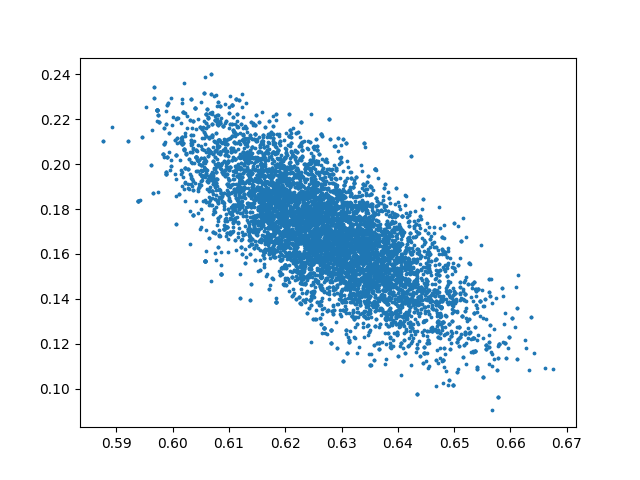

In [7]:
u1_sloan_r_chains = chains[0, :, 0]
u2_sloan_r_chains = chains[0, :, 1]

u1_tess_chains = chains[1, :, 0]
u2_tess_chains = chains[1, :, 1]

print(f'TESS LD coeff u1 = {np.median(u1_tess_chains):.4f} \pm {np.std(u1_tess_chains):.4f}')
print(f'Sloan r LD coeff u1 = {np.median(u1_sloan_r_chains):.3f} \pm {np.std(u1_sloan_r_chains):.3f}')

plt.figure()
plt.scatter(u1_sloan_r_chains, u2_sloan_r_chains, s=3)
plt.show()

In [8]:
print(f'{np.median(u1_tess_chains):.4f}')
print(f'{np.median(u2_tess_chains):.4f}')
print()
print(f'{np.median(u1_sloan_r_chains):.4f}')
print(f'{np.median(u2_sloan_r_chains):.4f}')


0.4961
0.1656

0.6270
0.1693


In [9]:
#overimpose the model with the TASTE and TESS normalized light curves

params_taste = batman.TransitParams()       #object to store transit parameters
params_taste.t0 = 2456851.481119             #time of inferior conjunction
params_taste.per = 3.21305762                    #orbital period
params_taste.rp = 0.1406                     #planet radius (in units of stellar radii)
params_taste.a = 11.77                     #semi-major axis (in units of stellar radii)
params_taste.inc = 89                    #orbital inclination (in degrees)
params_taste.ecc = 0.                       #eccentricity
params_taste.w = 90.                      #longitude of periastron (in degrees)
params_taste.limb_dark = "quadratic"        #limb darkening model
params_taste.u = [np.median(u1_sloan_r_chains), np.median(u2_sloan_r_chains)]                 #limb darkening coefficients [u1, u2, u3, u4]

m = batman.TransitModel(params_taste, taste_bjd)    #initializes model

flux_taste = m.light_curve(params_taste)

########################################################################################################

params_tess = batman.TransitParams()       #object to store transit parameters
params_tess.t0 = 2459685.398095            #time of inferior conjunction
params_tess.per = 3.213                    #orbital period
params_tess.rp = 0.139                     #planet radius (in units of stellar radii)
params_tess.a = 11.364                     #semi-major axis (in units of stellar radii)
params_tess.inc = 88.24                    #orbital inclination (in degrees)
params_tess.ecc = 0.                       #eccentricity
params_tess.w = 90.                     #longitude of periastron (in degrees)
params_tess.limb_dark = "quadratic"        #limb darkening model
params_tess.u = [np.median(u1_tess_chains), np.median(u2_tess_chains)]                 #limb darkening coefficients [u1, u2, u3, u4]

m = batman.TransitModel(params_tess, tess_bjd)    #initializes model

flux_tess = m.light_curve(params_tess)

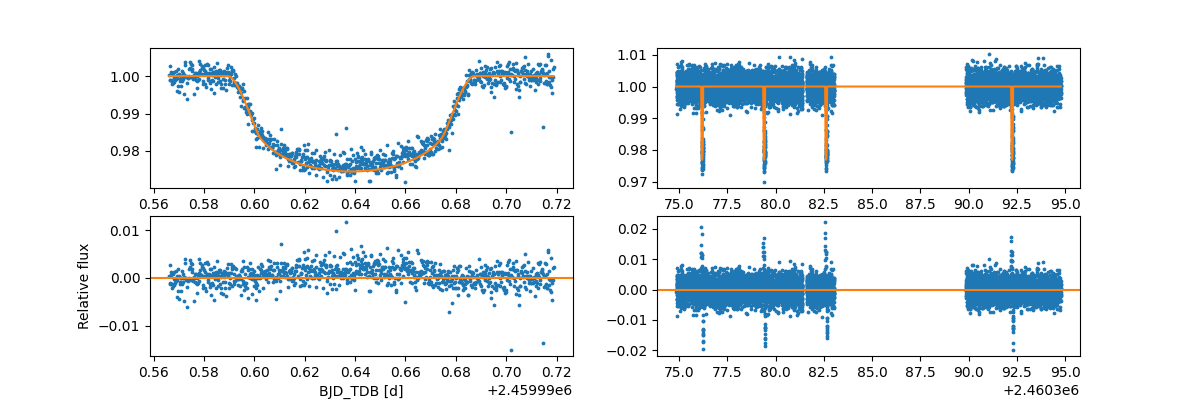

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4))
ax[0, 0].scatter(taste_bjd, normalized_differential_allref, s=3)
ax[0, 0].plot(taste_bjd, flux_taste, c='C1')

ax[0, 1].scatter(tess_bjd, tess_normalized_flux_76, s=3)
ax[0, 1].plot(tess_bjd, flux_tess, c='C1')

ax[1, 0].set_xlabel('BJD_TDB [d]')
ax[0, 1].set_xlabel('BJD_TDB [d]')
ax[1, 0].set_ylabel('Relative flux')

ax[1, 0].scatter(taste_bjd, normalized_differential_allref - flux_taste, s=3)
#ax[2].errorbar()
ax[1, 0].axhline(0, c='C1')

ax[1, 1].scatter(tess_bjd, tess_normalized_flux_76 - flux_tess, s=3)
ax[1, 1].axhline(0, c='C1')

plt.show()